In [1]:
from comet_ml import Experiment

hyper_params = {    
    "TASK": 4,
    "batch_size": 128, # initially was 64
    "NOISE_DIM": 30,
    "num_epochs": 300,
    "learning_rate": 0.001
}
experiment = Experiment(project_name="gan-test", workspace="shir994")
experiment.log_parameters(hyper_params)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/shir994/gan-test/1d786bb2f69b49df925df1292d61815f



In [1]:
%env CUDA_VISIBLE_DEVICES=3
%env LIBRARY_PATH=/usr/local/cuda/lib64

env: CUDA_VISIBLE_DEVICES=3
env: LIBRARY_PATH=/usr/local/cuda/lib64


In [2]:
%load_ext autoreload
%autoreload 2

from model import YModel, R
from gan.gan import Generator, Discriminator, WSDiscriminator, GANLosses
from gan.metrics import Metrics
from utils import sample_noise, iterate_minibatches, generate_data

# GANS

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

import numpy as np
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda", 0)

In [4]:
TASK = hyper_params['TASK']

NameError: name 'hyper_params' is not defined

In [5]:
generator = Generator(hyper_params['NOISE_DIM'], out_dim = 1).to(device)

if TASK == 4:
    discriminator = WSDiscriminator(in_dim=1).to(device)
else:
    discriminator = Discriminator(in_dim=1).to(device)

g_optimizer = optim.Adam(generator.parameters(),     lr=hyper_params['learning_rate'], betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=hyper_params['learning_rate'], betas=(0.5, 0.999))

NameError: name 'hyper_params' is not defined

In [34]:
y_sampler = YModel()
fixed_noise = torch.Tensor(sample_noise(10000, hyper_params['NOISE_DIM'])).to(device)
data, inputs = generate_data(y_sampler, device, 10000, mu_range=(-30, 30))
metric_calc = Metrics((-50, 50), 100)

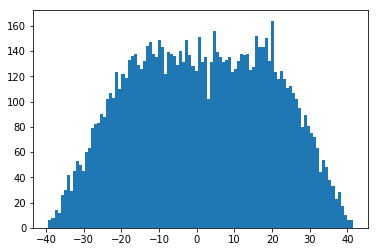

In [35]:
plt.hist(data.cpu().numpy(), bins=100);

In [64]:
def draw_conditional_samples(mu_range, x_range):
    f = plt.figure(figsize=(21,16))

    for i in range(4):
        x = torch.Tensor([float(x_range[i])] * 10000).to(device)
        for j in range(4):
            mu = torch.Tensor([float(mu_range[j])] * 10000).to(device)
            plt.subplot(4,4, i*4 + j + 1)

            y_sampler.make_condition_sample({'mu': mu, 'X':x})
            data = y_sampler.condition_sample().detach().cpu().numpy()

            plt.hist(data, bins=100, density=True, label='true');
            plt.hist(generator(fixed_noise, torch.stack([mu,x],dim=1)).detach().cpu().numpy(),
                     bins=100, color='g', density=True, alpha=0.5, label='gan');
            plt.grid()
            plt.legend()
            if j == 0:
                plt.ylabel("x={:.3f}".format(x[0].item()), fontsize=19)
            if i == 0:
                plt.title("mu={:.3f}".format(mu[0].item()), fontsize=19)            
    return f

def draw_mu_samples(mu_range):
    f = plt.figure(figsize=(21,16))
    for i in range(4):
        for j in range(3):
            plt.subplot(4,3, i*3 + j + 1)
            mu = torch.tensor([float(mu_range[i*3 + j])] * 10000)#.to(device)
            y_sampler.make_condition_sample({'mu': mu})

            x = y_sampler.x_dist.sample(mu.shape).to(device)
            mu = mu.to(device)

            plt.hist(y_sampler.condition_sample().cpu().numpy(), bins=100, density=True, label='true');
            plt.hist(generator(fixed_noise, torch.stack([mu,x],dim=1)).detach().cpu().numpy(),
                     bins=100, color='g', density=True, alpha=0.5, label='gan');
            plt.grid()
            plt.legend()
            plt.title("mu={:.3f} ".format(mu_range[i*3 + j])) 
    return f

def calculate_validation_metrics(mu_range, epoch):
    js = []
    for _mu in mu_range:
        mu = torch.tensor([float(_mu)] * 10000)
        y_sampler.make_condition_sample({'mu': mu})

        x = y_sampler.x_dist.sample(mu.shape).to(device)
        mu = mu.to(device)

        js.append(metric_calc.compute_JS(y_sampler.condition_sample().cpu(),
                  generator(fixed_noise, torch.stack([mu,x],dim=1)).detach().cpu()).item())
#                 average_mu_JS.append(np.mean(js))
    train_data_js = metric_calc.compute_JS(data.cpu(), generator(fixed_noise, inputs).detach().cpu())
#                 train_data_JS.append(train_data_js)

    experiment.log_metric("average_mu_JS", np.mean(js), step=epoch)
    experiment.log_metric("train_data_JS", train_data_js, step=epoch)    

In [65]:
from IPython import display
def run_training():
    #plt.xlim(lims)
    #plt.ylim(lims)

    # ===========================
    # IMPORTANT PARAMETER:
    # Number of D updates per G update
    # ===========================
    k_d, k_g = 4, 1

    dis_loss, gen_loss = [], []
    train_data_JS = []
    average_mu_JS = []
    gan_losses = GANLosses(TASK, device)

    try:
        with experiment.train():
            for epoch in range(hyper_params['num_epochs']):
                dis_epoch_loss = []
                gen_epoch_loss = []

                for input_data, inputs_batch in iterate_minibatches(data, hyper_params['batch_size'], y=inputs):
                    # Optimize D
                    for _ in range(k_d):
                        # Sample noise
                        noise = torch.Tensor(sample_noise(len(input_data), hyper_params['NOISE_DIM'])).to(device)

                        # Do an update
                        inp_data = input_data.to(device)
                        data_gen = generator(noise, inputs_batch)

                        loss = gan_losses.d_loss(discriminator(data_gen, inputs_batch),
                                                discriminator(inp_data, inputs_batch))
                        if TASK == 4:
                            grad_penalty = gan_losses.calc_gradient_penalty(discriminator,
                                                                            data_gen.data,
                                                                            inputs_batch.data,
                                                                            inp_data.data)
                            loss += grad_penalty

                        d_optimizer.zero_grad()
                        loss.backward()
                        d_optimizer.step()

                        if TASK == 3:                    
                            for p in discriminator.parameters():
                                p.data.clamp_(clamp_lower, clamp_upper)
                    dis_epoch_loss.append(loss.item())

                    # Optimize G
                    for _ in range(k_g):
                        # Sample noise
                        noise = torch.Tensor(sample_noise(len(input_data), hyper_params['NOISE_DIM'])).to(device)

                        # Do an update
                        data_gen = generator(noise, inputs_batch)
                        loss = gan_losses.g_loss(discriminator(data_gen, inputs_batch))
                        g_optimizer.zero_grad()
                        loss.backward()
                        g_optimizer.step()
                    gen_epoch_loss.append(loss.item())
                
                experiment.log_metric("d_loss", np.mean(dis_epoch_loss), step=epoch)
                experiment.log_metric("g_loss", np.mean(gen_epoch_loss), step=epoch)
#                 dis_loss.append(np.mean(dis_epoch_loss))
#                 gen_loss.append(np.mean(gen_epoch_loss))
                
                calculate_validation_metrics(list(range(-30, 30, 2)), epoch)
                
                mu_range = list(range(-10, 10, 4))
                x_range = list(range(1, 13, 3))
                f = draw_conditional_samples(mu_range, x_range)
                experiment.log_figure("conditional_samples", f)
                
                mu_range = list(range(-10, 13, 2))
                f = draw_mu_samples(mu_range)
                experiment.log_figure("mu_samples", f)
                
        return dis_loss, gen_loss, train_data_JS, average_mu_JS
    except KeyboardInterrupt:
        pass

In [66]:
%reload_ext autoreload

In [ ]:
losses = run_training()

  0%|          | 0/79 [00:00<?, ?it/s]/mnt/shirobokov/conda/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|██████████| 79/79 [00:02<00:00, 32.02it/s]
/mnt/shirobokov/conda/envs/pytorch/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
100%|██████████| 79/79 [00:02<00:00, 30.46it/s]
COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/shir994/gan-test/45365d46f7d04305b618d3f95845f644
COMET INFO:   Metrics:
COMET INFO:    

#  Conditional GAN simple results

In [ ]:
mu_range = list(range(-10, 10, 4))
x_range = list(range(1, 13, 3))
f = draw_conditional_samples(mu_range, x_range)

### Unconditional samples

In [29]:
mu_range = list(range(-10, 13, 2))

In [ ]:
draw_mu_samples

# Test on mu outside of training domain

Text(0.5, 1.0, 'mu=-80.000, x=1.000')

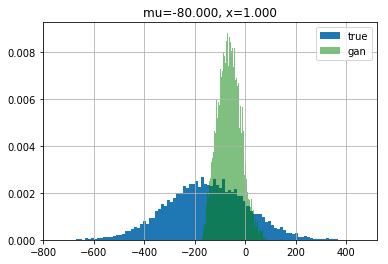

In [17]:
input_mu = torch.full(size=(10000, ), fill_value=-80.).to(device)
input_x = torch.full(size=(10000, ), fill_value=1.).to(device)

y_sampler.make_condition_sample({'mu': input_mu, 'X':input_x})
data = y_sampler.condition_sample().detach().cpu().numpy() 
            
plt.hist(data, bins=100, normed=True, label='true');
plt.hist(generator(fixed_noise, torch.stack([input_mu, input_x], dim=1)).detach().cpu().numpy(),
     bins=100, color='g', density=True, alpha=0.5, label='gan');
plt.grid()
plt.legend()
plt.title("mu={:.3f}, x={:.3f}".format(input_mu[0].item(), input_x[0].item()))

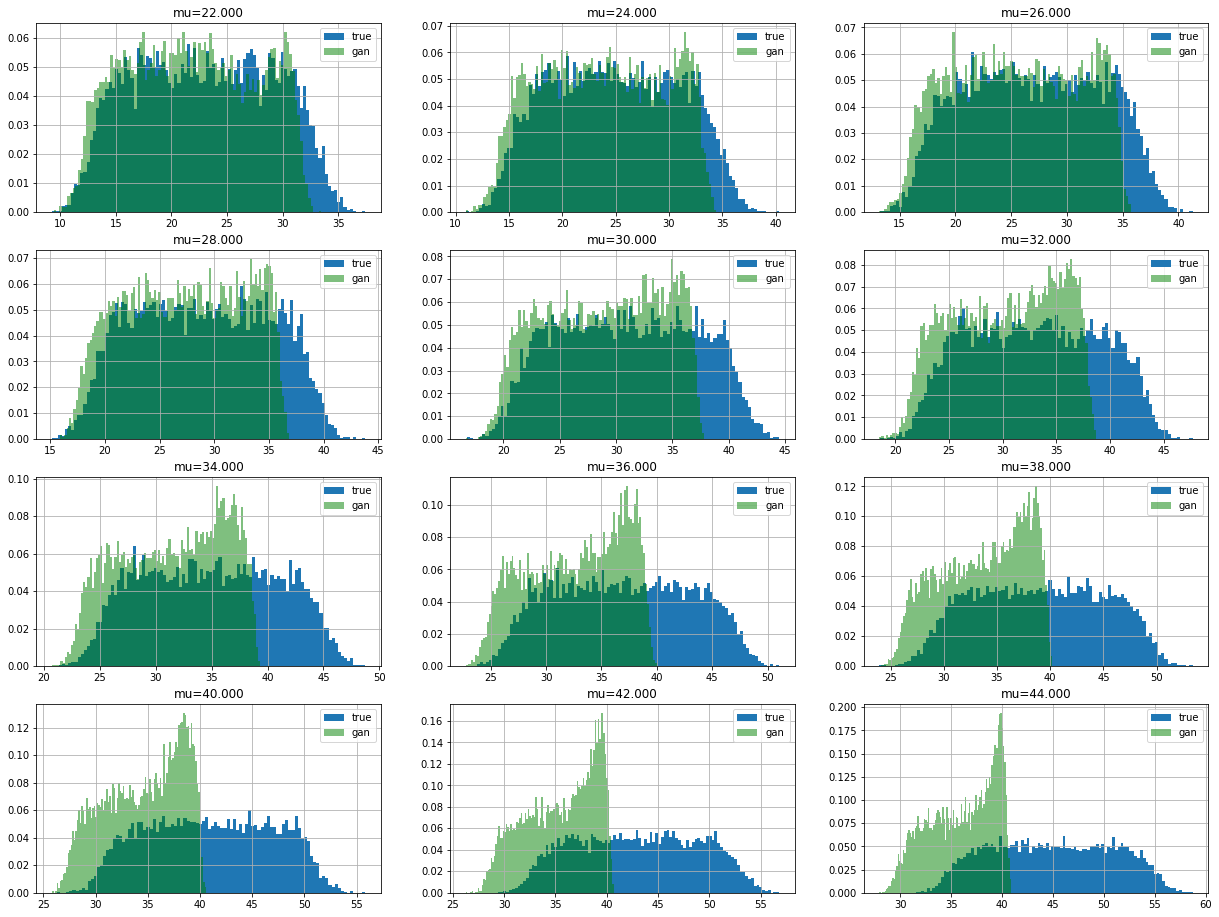

In [52]:
plt.figure(figsize=(21,16))
mu_range = list(range(22, 60, 2))
for i in range(4):
    for j in range(3):
        plt.subplot(4,3, i*3 + j + 1)
        input_mu = torch.full(size=(10000, ), fill_value=mu_range[i*3 + j])#.to(device)
        input_x = y_sampler.x_dist.sample(input_mu.shape).to(device)

        y_sampler.make_condition_sample({'mu': input_mu})
        data = y_sampler.condition_sample().detach().cpu().numpy()

        input_mu = input_mu.to(device)

        plt.hist(data, bins=100, normed=True, label='true');
        plt.hist(generator(fixed_noise, torch.stack([input_mu, input_x], dim=1)).detach().cpu().numpy(),
             bins=100, color='g', density=True, alpha=0.5, label='gan');
        plt.grid()
        plt.legend()
        plt.title("mu={:.3f}".format(input_mu[0].item()))

# Implementing simple marginalisation ?

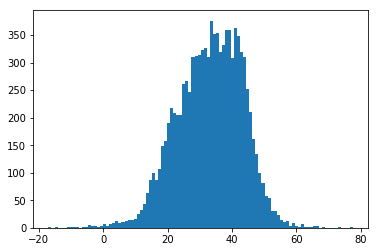

In [19]:
mu = torch.full((10000,), 0.).to(device)
x = y_sampler.x_dist.sample([mu.shape[0]]).to(device)
plt.hist(generator(fixed_noise, torch.stack([mu,x], dim=1)).detach().cpu().numpy(), bins=100);

In [20]:
#torch.save(generator, "new_gan.pt")
#generator = torch.load("new_gan.pt")

In [21]:
from copy import deepcopy

In [22]:
class InputOptimisation(nn.Module):
    def __init__(self, generator_model):
        super().__init__()
        self.gen = deepcopy(generator_model)
        for param in self.gen.parameters():
            param.requires_grad = False
        self.gen.eval()
        
#     def generate_random_samples(data, n_bins=300):
#         hist, bins = np.histogram(data, bins=n_bins);

#         bin_midpoints = bins[:-1] + np.diff(bins)/2
#         cdf = np.cumsum(hist)
#         cdf = cdf / cdf[-1]

#         samples = np.random.rand(100000)
#         value_bins = np.searchsorted(cdf, samples)
#         random_from_cdf = bin_midpoints[value_bins]        
        
        
    def forward(self, noise, inputs):
#         y_given_mu = []
#         for val in noise:
#             x = y_sampler.x_dist.sample([mu.shape[0]]).to(device)
#             local_noise = val.reshape(1,-1).repeat(mu.shape[0],1).to(device)
#             y = self.gen(local_noise, torch.stack([mu,x],dim=1)).mean()
#             y_given_mu.append(y)

#         return torch.stack(y_given_mu)
        return self.gen(noise, inputs)

In [23]:
io_model = InputOptimisation(generator)

lr = 0.1
# io_optimizer = optim.Adam(io_model.parameters(), lr=lr)

sample_size = 1000

In [24]:
mu_optim = torch.tensor(50.)

mu_optim = mu_optim.repeat(sample_size).to(device)
mu_optim.requires_grad=True

In [25]:
# %%time
# noise = torch.Tensor(sample_noise(sample_size)).to(device)
# io_model(noise, mu_optim)

In [26]:
%%time
n_iter = 10000
losses = []
m_vals = []
for _iter in range(n_iter):    
    noise = torch.Tensor(sample_noise(sample_size)).to(device)
    x = y_sampler.x_dist.sample([mu_optim.shape[0]]).to(device)
    # Do an update
    data_gen = io_model(noise, torch.stack([mu_optim, x], dim=1))
    loss = R(data_gen)
    losses.append(loss.item())
    io_model.zero_grad()
    loss.backward()
    with torch.no_grad():
        mu_optim -= lr * mu_optim.grad.mean()
        mu_optim.grad.zero_()
    m_vals.append(mu_optim[0].item())

CPU times: user 20.5 s, sys: 792 ms, total: 21.3 s
Wall time: 21.8 s


In [27]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

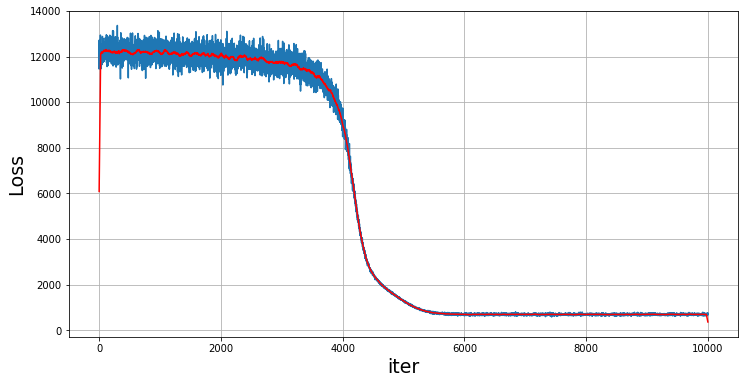

In [28]:
plt.figure(figsize=(12,6))
plt.plot(losses);
plt.grid()
plt.ylabel("Loss", fontsize=19)
plt.xlabel("iter", fontsize=19)
plt.plot((movingaverage(losses, 50)), c='r')

Text(0.5, 0, 'iter')

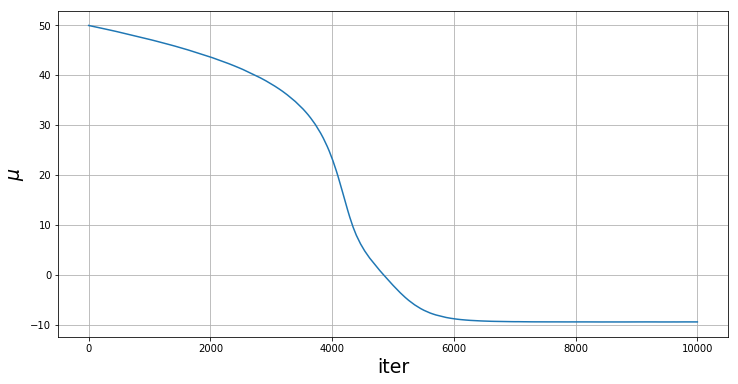

In [29]:
plt.figure(figsize=(12,6))
plt.plot(m_vals);
plt.grid()
plt.ylabel("$\mu$", fontsize=19)
plt.xlabel("iter", fontsize=19)

In [30]:
np.min(losses), mu_optim[0]

(582.8477172851562, tensor(-9.3814, device='cuda:0', grad_fn=<SelectBackward>))

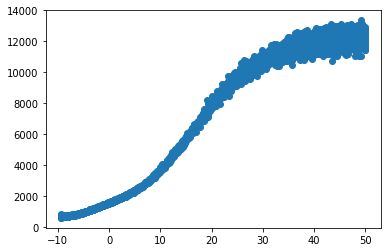

In [31]:
plt.scatter(m_vals, losses)